In [1]:
import numpy as np
import pandas as pd

import scorecardpy as sc

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/Users/tarlanjabiyev/Desktop/Sprint 18/churn.csv')

In [5]:
data

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,2,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,3,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,4,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,5,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,45207,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,45208,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,45209,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,45210,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


## Datanın təmizlənməsi - Data Cleaning

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         45211 non-null  int64 
 1   age        45211 non-null  int64 
 2   job        45211 non-null  object
 3   marital    45211 non-null  object
 4   education  45211 non-null  object
 5   default    45211 non-null  object
 6   balance    45211 non-null  int64 
 7   housing    45211 non-null  object
 8   loan       45211 non-null  object
 9   contact    45211 non-null  object
 10  day        45211 non-null  int64 
 11  month      45211 non-null  object
 12  duration   45211 non-null  int64 
 13  campaign   45211 non-null  int64 
 14  pdays      45211 non-null  int64 
 15  previous   45211 non-null  int64 
 16  poutcome   45211 non-null  object
 17  y          45211 non-null  object
dtypes: int64(8), object(10)
memory usage: 6.2+ MB


In [10]:
data["y"] = data["y"].replace({"yes": 1, "no": 0}).astype("category")

/var/folders/w5/0qbzsvvx23g_63j6m77_09nm0000gn/T/ipykernel_22516/1380780874.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["y"] = data["y"].replace({"yes": 1, "no": 0}).astype("category")


In [12]:
data["y"].value_counts(normalize=True).round(2)

y
0    0.88
1    0.12
Name: proportion, dtype: float64

In [14]:
na_df = data.isna().sum().reset_index().rename(columns={'index': 'col_name', 0: 'na_count'})
na_df = na_df.sort_values('na_count', ascending=False).reset_index(drop=True)
na_df

,col_name,na_count
0,id,0
1,age,0
2,poutcome,0
3,previous,0
4,pdays,0
5,campaign,0
6,duration,0
7,month,0
8,day,0
9,contact,0


In [16]:
target = "y"
exclude = ["id"]

## "Weight Of Evidence"

In [19]:
df_use = data.drop(columns=exclude, errors="ignore")

In [21]:
# IV (information values)

iv = sc.iv(df_use, y=target)      
iv["info_value"] = iv["info_value"].round(3)
iv = iv.sort_values("info_value", ascending=False)

iv

,variable,info_value
4,duration,1.667
7,balance,0.905
8,pdays,0.551
6,poutcome,0.515
2,month,0.436
13,contact,0.300
10,previous,0.232
14,age,0.226
1,housing,0.189
15,job,0.156


In [22]:
# IV dəyəri 0.02'dən kiçik olan dəyişənləri çıxarmaq

ivars = iv.loc[iv["info_value"] > 0.02, "variable"].tolist()
len(ivars)

15

In [25]:
df_iv = df_use[[target] + ivars]
df_iv.shape

(45211, 16)

In [27]:
# Datanın bölünməsi

dt_list = sc.split_df(df_iv, y=target, ratio=0.8, seed=123)
train, test = dt_list["train"], dt_list["test"]

/opt/anaconda3/lib/python3.12/site-packages/scorecardpy/split_df.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train = dt.groupby(y, group_keys=False)\


In [29]:
print(df_iv.shape)
print(train.shape)
print(test.shape)

(45211, 16)
(36169, 16)
(9042, 16)


In [31]:
# woe binning 

bins = sc.woebin(train, y=target)

[INFO] creating woe binning ...


/opt/anaconda3/lib/python3.12/site-packages/scorecardpy/condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/opt/anaconda3/lib/python3.12/site-packages/scorecardpy/condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/opt/anaconda3/lib/python3.12/site-packages/scorecardpy/condition_fun.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensur

In [33]:
bins["age"]

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,age,"[-inf,30.0)",4210,0.116398,3480,730,0.173397,0.459615,0.029220,0.124103,30.0,False
1,age,"[30.0,38.0)",12075,0.333849,10755,1320,0.109317,-0.076381,0.001891,0.124103,38.0,False
2,age,"[38.0,58.0)",17246,0.476817,15663,1583,0.091789,-0.270621,0.031467,0.124103,58.0,False
3,age,"[58.0,inf)",2638,0.072935,2040,598,0.226687,0.794244,0.061525,0.124103,inf,False


{'age': <Figure size 640x480 with 2 Axes>}

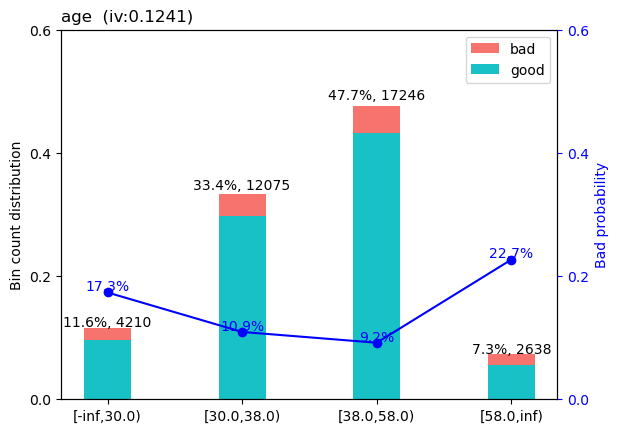

In [35]:
sc.woebin_plot(bins['age'])

In [37]:
bins["marital"]

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,marital,married,21794,0.602560,19589,2205,0.101175,-0.162883,0.015016,0.039726,married,False
1,marital,divorced,4204,0.116232,3695,509,0.121075,0.039070,0.000180,0.039726,divorced,False
2,marital,single,10171,0.281208,8654,1517,0.149150,0.280071,0.024529,0.039726,single,False


{'marital': <Figure size 640x480 with 2 Axes>}

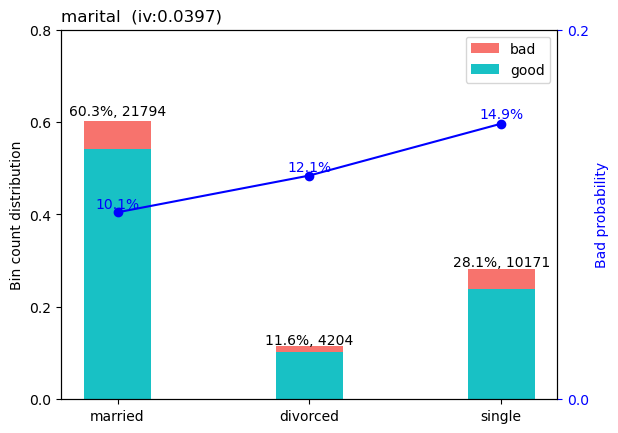

In [39]:
sc.woebin_plot(bins['marital'])

In [41]:
train_woe = sc.woebin_ply(train, bins)
test_woe  = sc.woebin_ply(test,  bins)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [42]:
train_woe.head()

,y,job_woe,previous_woe,loan_woe,education_woe,campaign_woe,housing_woe,day_woe,marital_woe,month_woe,contact_woe,age_woe,poutcome_woe,duration_woe,balance_woe,pdays_woe
1,0,-0.008165,-0.271136,0.087976,-0.118738,0.257381,-0.466455,-0.160041,0.280071,-0.604301,-1.115243,-0.270621,-0.270472,-0.665447,-0.332277,-0.270062
2,0,-0.433184,-0.271136,-0.607869,-0.118738,0.257381,-0.466455,-0.160041,-0.162883,-0.604301,-1.115243,-0.076381,-0.270472,-1.822221,-0.332277,-0.270062
3,0,-0.433184,-0.271136,0.087976,0.273860,0.257381,-0.466455,-0.160041,-0.162883,-0.604301,-1.115243,-0.270621,-0.270472,-1.822221,0.176662,-0.270062
5,0,0.207998,-0.271136,0.087976,0.273860,0.257381,-0.466455,-0.160041,-0.162883,-0.604301,-1.115243,-0.076381,-0.270472,-0.665447,0.008488,-0.270062
6,0,0.207998,-0.271136,-0.607869,0.273860,0.257381,-0.466455,-0.160041,0.280071,-0.604301,-1.115243,0.459615,-0.270472,0.273719,0.008488,-0.270062


In [43]:
train_woe.columns = train_woe.columns.str.replace("_woe", "")
test_woe.columns = train_woe.columns

train_woe.head()

,y,job,previous,loan,education,campaign,housing,day,marital,month,contact,age,poutcome,duration,balance,pdays
1,0,-0.008165,-0.271136,0.087976,-0.118738,0.257381,-0.466455,-0.160041,0.280071,-0.604301,-1.115243,-0.270621,-0.270472,-0.665447,-0.332277,-0.270062
2,0,-0.433184,-0.271136,-0.607869,-0.118738,0.257381,-0.466455,-0.160041,-0.162883,-0.604301,-1.115243,-0.076381,-0.270472,-1.822221,-0.332277,-0.270062
3,0,-0.433184,-0.271136,0.087976,0.273860,0.257381,-0.466455,-0.160041,-0.162883,-0.604301,-1.115243,-0.270621,-0.270472,-1.822221,0.176662,-0.270062
5,0,0.207998,-0.271136,0.087976,0.273860,0.257381,-0.466455,-0.160041,-0.162883,-0.604301,-1.115243,-0.076381,-0.270472,-0.665447,0.008488,-0.270062
6,0,0.207998,-0.271136,-0.607869,0.273860,0.257381,-0.466455,-0.160041,0.280071,-0.604301,-1.115243,0.459615,-0.270472,0.273719,0.008488,-0.270062


## 'Multicollinearity' probleminin həll olunması və VIF (Variance Inflation Factor)

In [47]:
X_data = train_woe.drop(columns = [target])

In [49]:
def compute_vif_table(X_data):
    vifs = {}
    
    for feature in X_data.columns:
        y = X_data[feature]
        X = X_data.drop(columns=[feature])
    
        model = LinearRegression().fit(X, y)
        r_squared = model.score(X, y)
    
        if r_squared == 1.0:
            vif = np.inf
        else:
            vif = 1 / (1 - r_squared)
            
        vifs[feature] = vif

    vif_values = pd.DataFrame(list(vifs.items()), columns=['Feature', 'VIF'])
    vif_values = vif_values[~np.isinf(vif_values['VIF'])].sort_values('VIF', ascending=False).reset_index()
    return(vif_values)

In [51]:
vif_values = compute_vif_table(X_data)
vif_values

,index,Feature,VIF
0,1,previous,4.596021
1,14,pdays,3.536360
2,11,poutcome,2.430658
3,9,contact,1.282282
4,0,job,1.279674
5,8,month,1.228528
6,3,education,1.162295
7,5,housing,1.161220
8,10,age,1.138735
9,13,balance,1.057929


In [53]:
features = vif_values.Feature
len(features)

15

In [55]:
while vif_values.loc[0, 'VIF'] >= 2 and len(features) > 1:
    print(vif_values.loc[0,['Feature','VIF']]) 
    
    features = vif_values.loc[1:, 'Feature'].tolist()
    print('Number of features:',len(features))
    
    X_data = X_data[features]
    vif_values = compute_vif_table(X_data)

Feature    previous
VIF        4.596021
Name: 0, dtype: object
Number of features: 14


In [57]:
vif_values

,index,Feature,VIF
0,0,pdays,1.950562
1,1,poutcome,1.910471
2,3,job,1.278682
3,2,contact,1.244449
4,4,month,1.227768
5,5,education,1.161280
6,7,age,1.138130
7,6,housing,1.121440
8,8,balance,1.057375
9,9,marital,1.054429


In [59]:
train = train_woe[[target] + features]
test = test_woe[[target] + features]

## GLM (Generalized Linear Model) alqoritmasının qurulması
## Proqnozlaşdırıcıların əhəmiyyət səviyyələri - Significance levels of predictors

In [61]:
def fit_logit_return_pvals(train, y, x):
    formula = f'{y} ~ {' + '.join(x)}'

    model = smf.glm(formula=formula, data=train, family=sm.families.Binomial()).fit()

    coef_tab = pd.DataFrame({
        'names': model.params.index.tolist(),
        'estimate': model.params.values,
        'std_error': model.bse.values,
        'z_value': model.tvalues,  
        'p_value': model.pvalues.values
    })

    p_values = (
        coef_tab.loc[coef_tab["names"] != "Intercept", ["names", "p_value"]]
        .sort_values("p_value", ascending=False)
        .reset_index(drop=True)
    )

    return model, coef_tab, p_values

model, coef_tab, p_values = fit_logit_return_pvals(train, target, features)

In [63]:
p_values.sort_values('p_value', ascending=False)

,names,p_value
0,job,8.243290e-07
1,pdays,1.366735e-08
2,education,1.180780e-09
3,marital,7.229211e-11
4,loan,4.209496e-11
5,age,8.310148e-14
6,balance,7.406085e-14
7,campaign,2.045336e-15
8,contact,2.205331e-25
9,day,2.006677e-27


## Addım-addım geriyə doğru aradan qaldırılma - Stepwise Backward Elimination

In [66]:
while (p_values.loc[0, 'p_value'] >= 0.05):
    worst_name = p_values.loc[0, 'names']
    print(p_values.loc[0])  
    
    features = features.drop(worst_name) # drop worst and refit
    model, coef_tab, p_values = fit_logit_return_pvals(train, target, features)

In [68]:
final_pvals = coef_tab[['names', 'p_value']].sort_values('p_value', ascending=False)
final_pvals.shape

(15, 2)

## Proqnozlar

In [71]:
X_test = sm.add_constant(test[features], has_constant='add')
X_test.head()

,const,pdays,poutcome,contact,job,month,education,housing,age,balance,marital,campaign,duration,loan,day
0,1.0,-0.270062,-0.270472,-1.115243,0.207998,-0.604301,0.273860,-0.466455,0.794244,0.382519,-0.162883,0.257381,0.273719,0.087976,-0.160041
4,1.0,-0.270062,-0.270472,-1.115243,-0.008165,-0.604301,0.273860,0.418872,-0.076381,-0.332277,0.280071,0.257381,-0.665447,0.087976,-0.160041
13,1.0,-0.270062,-0.270472,-1.115243,-0.008165,-0.604301,0.273860,-0.466455,0.794244,-0.332277,-0.162883,0.257381,-1.822221,0.087976,-0.160041
17,1.0,-0.270062,-0.270472,-1.115243,-0.433184,-0.604301,-0.318586,-0.466455,-0.270621,-0.332277,-0.162883,0.257381,-4.412118,0.087976,-0.160041
22,1.0,-0.270062,-0.270472,-1.115243,-0.433184,-0.604301,-0.318586,-0.466455,-0.076381,-0.332277,0.280071,0.257381,-0.665447,-0.607869,-0.160041


In [73]:
actual = test[target]

In [75]:
pred_prob = model.predict(X_test)

## Optimal "Threshold" tapılması

In [78]:
results = pd.DataFrame({
    "pred_prob": np.round(np.asarray(pred_prob, dtype=float), 4),
    "actual":    np.asarray(actual, dtype=int)
})
results.head()

,pred_prob,actual
0,0.9293,0
1,0.9696,0
2,0.9956,0
3,0.9999,0
4,0.9935,0


In [80]:
thresholds = np.round(np.arange(0.0, 1.01, 0.01), 2)
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [82]:
def f1_at_thr(thr):
    preds_class = (results["pred_prob"].values > thr)
    return f1_score(results["actual"].values, preds_class, zero_division=0)

f1_scores = np.array([f1_at_thr(t) for t in thresholds])

In [84]:
f1_scores

array([0.20950495, 0.20950495, 0.20950495, 0.20915033, 0.20885762,
       0.20850263, 0.20834572, 0.20765569, 0.20712231, 0.20676654,
       0.20587651, 0.20571882, 0.20554066, 0.20524538, 0.20385839,
       0.20282643, 0.20141448, 0.20057821, 0.1998004 , 0.19856173,
       0.19758024, 0.19673772, 0.1960745 , 0.19464769, 0.19360016,
       0.19273238, 0.19186339, 0.19101237, 0.18983392, 0.18806692,
       0.18688194, 0.18569408, 0.18424512, 0.18354751, 0.18133874,
       0.17865854, 0.1778049 , 0.17642864, 0.17528824, 0.17507661,
       0.17389525, 0.17227235, 0.17104723, 0.16838205, 0.16761159,
       0.16589195, 0.16446007, 0.16182573, 0.16048228, 0.15815795,
       0.15624021, 0.1539267 , 0.15164881, 0.14931031, 0.1464497 ,
       0.14414414, 0.14231015, 0.14075496, 0.13812273, 0.13513514,
       0.13273099, 0.13074434, 0.1278944 , 0.12482362, 0.12244009,
       0.1186385 , 0.11463146, 0.11112338, 0.10675841, 0.10347904,
       0.10039216, 0.09837911, 0.0952381 , 0.09128158, 0.08720

In [86]:
thresholds_df = pd.DataFrame({
    "thresholds": thresholds,
    "f1_scores": f1_scores
})
thresholds_df

,thresholds,f1_scores
0,0.00,0.209505
1,0.01,0.209505
2,0.02,0.209505
3,0.03,0.209150
4,0.04,0.208858
...,...,...
96,0.96,0.013382
97,0.97,0.010501
98,0.98,0.006646
99,0.99,0.004989


In [88]:
max_f1 = np.nanmax(f1_scores)
opt_thresh = thresholds_df.loc[thresholds_df.f1_scores == max_f1,"thresholds"].max()
opt_thresh

0.0

In [90]:
pred_class = np.where(results["pred_prob"].values > opt_thresh, "1", "0")
pred_class = pd.Series(pred_class)

## Klassifikasiya Modelinin Perormansının Qiymətləndirilməsi

### Qarışıqlıq matrisi - Confision Matrix

In [94]:
y_true = np.asarray(actual, dtype=int)
y_preds = np.asarray(pred_class, dtype=int)

In [96]:
cm = confusion_matrix(y_true, y_preds, labels=[0, 1])
cm

array([[   0, 7984],
       [   0, 1058]])

In [98]:
cm_df = pd.DataFrame(cm,
                     index=pd.Index([0,1], name="Actual"),
                     columns=pd.Index([0,1], name="Predicted"))
cm_df

Predicted,0,1
Actual,,
0,0,7984
1,0,1058


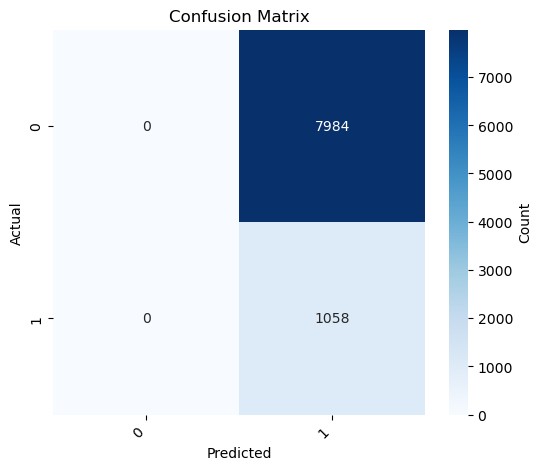

In [100]:
plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    cm_df,
    annot=True, fmt="d",
    cmap="Blues", vmin=0,
    cbar_kws={"label": "Count"}
)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

In [102]:
tn, fp, fn, tp = cm.ravel()

In [104]:
precision            = tp/(tp + fp)
recall_sensitivity   = tp/(tp + fn)    
specificity          = tn/(tn + fp)  
accuracy             = (tp + tn)/cm.sum()
f1_score             = 2 * precision * recall_sensitivity/(precision + recall_sensitivity)
balanced_accuracy    = (recall_sensitivity + specificity) / 2

In [106]:
pd.DataFrame([{
    "precision": precision,
    "recall_sensitivity": recall_sensitivity,
    "specificity": specificity,
    "accuracy": accuracy,
    "f1_score": f1_score,
    "balanced_accuracy": balanced_accuracy
}])

,precision,recall_sensitivity,specificity,accuracy,f1_score,balanced_accuracy
0,0.11701,1.0,0.0,0.11701,0.209505,0.5


### Area Under Curve (AUC) və ROC əyrisi

In [109]:
scores = np.asarray(pred_prob, dtype=float)

In [111]:
fpr, tpr, thr = roc_curve(y_true, scores)     
auc = roc_auc_score(y_true, scores)
auc

0.10528642350864299

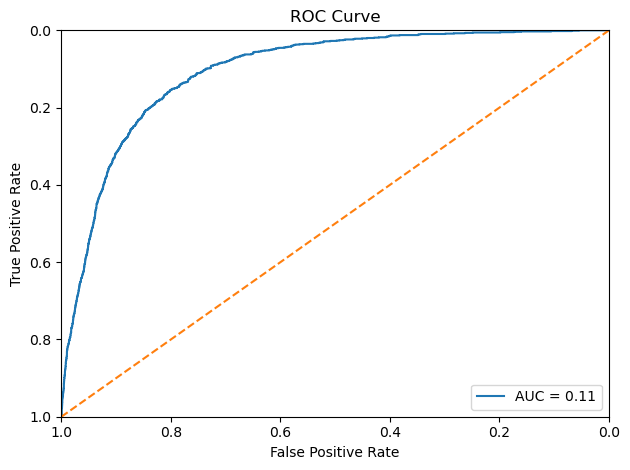

In [113]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
ax.plot([0, 1], [0, 1], linestyle="--")
ax.set_xlim(1, 0); ax.set_ylim(1, 0)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve")
ax.legend(loc="lower right")
fig.tight_layout()

## 'Overfitting' / 'Underfitting'

In [116]:
X_train = sm.add_constant(train[features], has_constant='add')
actual_train = train[target].astype(float)
pred_prob_train = model.predict(X_train)

In [118]:
y_true = np.asarray(actual_train, dtype=int)
scores_train = np.asarray(pred_prob_train, dtype=float)

In [122]:
fpr, tpr, thr = roc_curve(y_true, scores_train)     
auc_train = roc_auc_score(y_true, scores_train)
auc_train

0.10539689882188574

In [125]:
print('Train:',round(auc_train,2),'\n',
      'Test:',round(auc,2))

Train: 0.11 
 Test: 0.11
